# Multiomics modeling

Let's look at the paper *"Multiomics modeling of the immunome, transcriptome, microbiome, proteome and metabolome adaptations during human pregnancy"* by **Ghaemi et al. 2019** (`task1_multiomics_ghaemi2019multiomics.pdf`).
The idea is to use biological measurements to characterize biological changes during pregnancy.
The authors use multiple modalities (measurements collected from the immune system, microbiome, etc.)
This includes whether we can predict the gestational age of a mother solely based on the collected biomarkers.

**Note**: There is no need to get acquainted with multiomics modeling, at least for this exercise. In the end, this is just a regular data science task :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Loading the necessary Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

import pandas as pd
import numpy as np
import pickle

## Load the data

Load the data from `multiomics_data.pickle` using `pickle`. You will get a [pandas](https://pandas.pydata.org/docs/user_guide/10min.html) DataFrame containing preprocessed data from the paper (the original data from their paper is a bit messy). The data contains several meta attributes as well as the different modalities.

Meta attributes include:

* `Sex`: sex of the baby
* `timepoint`: 1-3 correspond to the three trimesters, 4 corresponds to postpartum
* `gestational_age`: time of sampling

Modalites are:
    
* `cellfree_rna`
* `metabolomics`
* `microbiome`
* `plasma_luminex`
* `serum_luminex`
* `immune_system`
* `plasma_somalogic`

For more details pleaase see the paper.

In [ ]:
#Step 1 Loading dataset
# code for loading the data
# pd.read_pickle(r'/content/drive/MyDrive/bckrlab-exercises/task1_multiomics_data.pickle')
with open("/content/drive/MyDrive/bckrlab-exercises/task1_multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)

data_multiomics


Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                            
0                    T  PTLG002  16661779                   10565    Male   
1                    T  PTLG002  16661779                   10565    Male   
2                    T  PTLG002  16661779                   10565    Male   
3                    T  PTLG002  16661779                   10565    Male   
4                    T  PTLG004  23587868                   10603  Female   
..                 ...      ...       ...                     ...     ...   
63                   T  PTLG029  40310948                   10631  Female   
64                   T  PTLG016  20328266                   30101    Male   
65                   T  PTLG016  20328266                   30101    Male   
66                   T  PTLG016  20328266                   30101    Male   
67                   T  PTLG016  20328266                   30101    Male   

   sex_bin timepoint gestational_age cellfree_rna                ...  \
                                        0_C2orf76      1_ACTL10  ...   
0        1         1              11     0.312437 -1.892930e-16  ...   
1        1         2              18     0.312437 -1.892930e-16  ...   
2        1         3              32     0.312437 -1.892930e-16  ...   
3        1         4              45     0.312437 -1.892930e-16  ...   
4        0         1              11     5.204209  1.734736e+00  ...   
..     ...       ...             ...          ...           ...  ...   
63       0         4              46     0.312437 -1.892930e-16  ...   
64       1         1              10     0.000000  0.000000e+00  ...   
65       1         2              19     0.000000  0.000000e+00  ...   
66       1         3              31     0.000000  0.000000e+00  ...   
67       1         4              47     0.000000  0.000000e+00  ...   

   plasma_somalogic                                               \
        1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1   
0            4804.4      2233.0     3610.9     715.8       151.4   
1            4086.0      2160.5     2260.4     825.2       161.0   
2            4328.0      1818.4     2445.2    1241.8       194.6   
3            3442.4      2661.4     3879.2     703.6       153.7   
4            4261.9      1804.6     1470.6     526.8       163.0   
..              ...         ...        ...       ...         ...   
63           4391.7      2458.9     3245.9     582.9       243.3   
64           3622.7      2625.1     3154.4     414.9       164.2   
65           5090.5      2206.1     2860.7     706.7       176.6   
66           5043.6      1894.1     1905.7     938.7       211.6   
67           4296.6      2278.2     2777.4     668.0       165.0   

                                                             
   1295_SERPINF1 1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0        37885.8    1479.1    3261.8      561.3      3227.0  
1        41821.5    1465.1    1839.8      597.8      3366.0  
2        45526.1    1428.3    3057.2      625.7      8703.7  
3        36862.5    1063.6    7339.7      593.2      2918.9  
4        38938.3    1170.1    1036.8      552.8      3457.1  
..           ...       ...       ...        ...         ...  
63       33475.3    1322.6   19361.7     1750.4      3012.4  
64       40142.8    1417.0    2424.4      725.2      3066.3  
65       38453.5    1811.2    1737.5      737.2      3340.8  
66       47249.5    2521.8    1026.5      667.2      5981.0  
67       45130.9    1781.2    5904.1      697.3      3246.2  

[68 rows x 61274 columns]

In [ ]:
# look at the immune system
immune_system=data_multiomics["immune_system"]
immune_system

,0_Bcells,1_CD16+CD56-NKcells,2_CD4+Tcells_mem,3_CD4+Tcells_naive,4_CD4+Tcells,5_CD45RA+Tregs,6_CD45RA-Tregs,7_CD56+CD16-NKcells,8_CD7+NKcells,9_CD8+Tcells_mem,...,524_M-MDSC_STAT5_Unstim,525_mDCs_STAT5_Unstim,526_ncMCs_STAT5_Unstim,527_pDCs_STAT5_Unstim,528_Tbet+CD4+Tcells_mem_STAT5_Unstim,529_Tbet+CD4+Tcells_naive_STAT5_Unstim,530_Tbet+CD8+Tcells_mem_STAT5_Unstim,531_Tbet+CD8+Tcells_naive_STAT5_Unstim,532_TCRgd+Tcells_STAT5_Unstim,533_Tregs_STAT5_Unstim
0,0.053164,0.054978,0.297875,0.136289,0.445832,0.002570,0.013848,0.007052,0.070836,0.118884,...,0.998954,0.953637,1.082629,0.808610,0.504269,0.757424,0.462045,0.454665,0.443859,0.529431
1,0.052857,0.069794,0.279917,0.140350,0.430839,0.002470,0.010923,0.004759,0.080245,0.127831,...,0.930847,0.822618,0.931126,0.728738,0.613059,0.852393,0.506981,0.474408,0.491691,0.574133
2,0.053202,0.050829,0.277997,0.187659,0.479078,0.003473,0.013359,0.005302,0.063781,0.104513,...,1.077824,0.970954,1.011011,0.749277,0.752882,0.813249,0.560379,0.481862,0.505706,0.640245
3,0.049906,0.090496,0.266336,0.156263,0.432904,0.003071,0.014459,0.004318,0.101386,0.115243,...,0.976888,0.918164,1.028114,0.790166,0.505349,0.648406,0.464522,0.445444,0.438285,0.573058
4,0.103067,0.004128,0.162746,0.103950,0.270840,0.003198,0.007988,0.007153,0.090763,0.057064,...,0.890405,0.800468,1.067789,0.563615,0.464563,1.004497,0.378557,0.423530,0.332368,0.447904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.091121,0.126476,0.143706,0.048464,0.195000,0.004209,0.007141,0.002082,0.169851,0.148295,...,1.108355,0.797910,0.892495,0.753036,0.531549,0.831332,0.425889,0.412894,0.378466,0.558786
64,0.070466,0.070750,0.247024,0.194472,0.462523,0.003692,0.009168,0.002431,0.077975,0.082531,...,0.913312,0.717190,0.758279,0.604196,0.600195,1.291782,0.443706,0.462645,0.371572,0.861217
65,0.061253,0.041134,0.236547,0.237067,0.496289,0.005648,0.011004,0.001758,0.047221,0.093727,...,0.954390,0.684022,0.740287,0.613545,0.604309,1.125464,0.434801,0.458300,0.406314,0.587349
66,0.052479,0.030232,0.210169,0.245472,0.478379,0.007130,0.008604,0.003692,0.039343,0.084122,...,0.938450,0.762454,0.795962,0.607801,0.622691,1.121270,0.443660,0.474322,0.411770,0.554895


In [ ]:
print(type(immune_system))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# 'gestational_age' is the target column
target_column_name = 'gestational_age'

# Check if the target column exists
if target_column_name not in immune_system.columns:
    print(f"The target column '{target_column_name}' does not exist in the dataset.")

else:
    # Split the dataset into features (X) and target variable (y)
    X = immune_system.drop(columns=[target_column_name])
    # X = immune_system.drop(columns=[target_column_name], level=0)  # Drop columns at level 0 of the column index
    y = immune_system[target_column_name]

The target column 'gestational_age' does not exist in the dataset.


In [ ]:
# Resetting the index of the main dataset to align with the working data's(immune system modality) index
main_dataset_reset = data_multiomics.reset_index(level=0)

# Then, merge or join the 'gestational_age' column from the main dataset to the working data based on the common index
immune_system=pd.concat([immune_system, main_dataset_reset['Study Subject ID Number']],axis=1)
immune_system = pd.concat([immune_system, main_dataset_reset['gestational_age']], axis=1)

In [ ]:
immune_system

,0_Bcells,1_CD16+CD56-NKcells,2_CD4+Tcells_mem,3_CD4+Tcells_naive,4_CD4+Tcells,5_CD45RA+Tregs,6_CD45RA-Tregs,7_CD56+CD16-NKcells,8_CD7+NKcells,9_CD8+Tcells_mem,...,526_ncMCs_STAT5_Unstim,527_pDCs_STAT5_Unstim,528_Tbet+CD4+Tcells_mem_STAT5_Unstim,529_Tbet+CD4+Tcells_naive_STAT5_Unstim,530_Tbet+CD8+Tcells_mem_STAT5_Unstim,531_Tbet+CD8+Tcells_naive_STAT5_Unstim,532_TCRgd+Tcells_STAT5_Unstim,533_Tregs_STAT5_Unstim,Study Subject ID Number,gestational_age
0,0.053164,0.054978,0.297875,0.136289,0.445832,0.002570,0.013848,0.007052,0.070836,0.118884,...,1.082629,0.808610,0.504269,0.757424,0.462045,0.454665,0.443859,0.529431,10565,11
1,0.052857,0.069794,0.279917,0.140350,0.430839,0.002470,0.010923,0.004759,0.080245,0.127831,...,0.931126,0.728738,0.613059,0.852393,0.506981,0.474408,0.491691,0.574133,10565,18
2,0.053202,0.050829,0.277997,0.187659,0.479078,0.003473,0.013359,0.005302,0.063781,0.104513,...,1.011011,0.749277,0.752882,0.813249,0.560379,0.481862,0.505706,0.640245,10565,32
3,0.049906,0.090496,0.266336,0.156263,0.432904,0.003071,0.014459,0.004318,0.101386,0.115243,...,1.028114,0.790166,0.505349,0.648406,0.464522,0.445444,0.438285,0.573058,10565,45
4,0.103067,0.004128,0.162746,0.103950,0.270840,0.003198,0.007988,0.007153,0.090763,0.057064,...,1.067789,0.563615,0.464563,1.004497,0.378557,0.423530,0.332368,0.447904,10603,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.091121,0.126476,0.143706,0.048464,0.195000,0.004209,0.007141,0.002082,0.169851,0.148295,...,0.892495,0.753036,0.531549,0.831332,0.425889,0.412894,0.378466,0.558786,10631,46
64,0.070466,0.070750,0.247024,0.194472,0.462523,0.003692,0.009168,0.002431,0.077975,0.082531,...,0.758279,0.604196,0.600195,1.291782,0.443706,0.462645,0.371572,0.861217,30101,10
65,0.061253,0.041134,0.236547,0.237067,0.496289,0.005648,0.011004,0.001758,0.047221,0.093727,...,0.740287,0.613545,0.604309,1.125464,0.434801,0.458300,0.406314,0.587349,30101,19
66,0.052479,0.030232,0.210169,0.245472,0.478379,0.007130,0.008604,0.003692,0.039343,0.084122,...,0.795962,0.607801,0.622691,1.121270,0.443660,0.474322,0.411770,0.554895,30101,31


In [ ]:
a=immune_system['Study Subject ID Number']
a

0     10565
1     10565
2     10565
3     10565
4     10603
      ...  
63    10631
64    30101
65    30101
66    30101
67    30101
Name: Study Subject ID Number, Length: 68, dtype: int64

In [ ]:
print(type(immune_system['Study Subject ID Number']))
print("Shape of subject_ids:", immune_system['Study Subject ID Number'].shape)
print("Length of subject_ids:", len(immune_system['Study Subject ID Number']))
immune_system['Study Subject ID Number'].size
print("Shape = {}".format(immune_system['Study Subject ID Number']))

<class 'pandas.core.series.Series'>
Shape of subject_ids: (68,)
Length of subject_ids: 68
Shape = 0     10565
1     10565
2     10565
3     10565
4     10603
      ...  
63    10631
64    30101
65    30101
66    30101
67    30101
Name: Study Subject ID Number, Length: 68, dtype: int64


## Tasks

### Gestational Age

In [ ]:
    # Split the dataset into features (X) and target variable (y)
    X = immune_system.drop(columns=['gestational_age'])
    # X = immune_system.drop(columns=[target_column_name], level=0)  # Drop columns at level 0 of the column index
    Y= immune_system['gestational_age']

In [ ]:
X

,0_Bcells,1_CD16+CD56-NKcells,2_CD4+Tcells_mem,3_CD4+Tcells_naive,4_CD4+Tcells,5_CD45RA+Tregs,6_CD45RA-Tregs,7_CD56+CD16-NKcells,8_CD7+NKcells,9_CD8+Tcells_mem,...,525_mDCs_STAT5_Unstim,526_ncMCs_STAT5_Unstim,527_pDCs_STAT5_Unstim,528_Tbet+CD4+Tcells_mem_STAT5_Unstim,529_Tbet+CD4+Tcells_naive_STAT5_Unstim,530_Tbet+CD8+Tcells_mem_STAT5_Unstim,531_Tbet+CD8+Tcells_naive_STAT5_Unstim,532_TCRgd+Tcells_STAT5_Unstim,533_Tregs_STAT5_Unstim,Study Subject ID Number
0,0.053164,0.054978,0.297875,0.136289,0.445832,0.002570,0.013848,0.007052,0.070836,0.118884,...,0.953637,1.082629,0.808610,0.504269,0.757424,0.462045,0.454665,0.443859,0.529431,10565
1,0.052857,0.069794,0.279917,0.140350,0.430839,0.002470,0.010923,0.004759,0.080245,0.127831,...,0.822618,0.931126,0.728738,0.613059,0.852393,0.506981,0.474408,0.491691,0.574133,10565
2,0.053202,0.050829,0.277997,0.187659,0.479078,0.003473,0.013359,0.005302,0.063781,0.104513,...,0.970954,1.011011,0.749277,0.752882,0.813249,0.560379,0.481862,0.505706,0.640245,10565
3,0.049906,0.090496,0.266336,0.156263,0.432904,0.003071,0.014459,0.004318,0.101386,0.115243,...,0.918164,1.028114,0.790166,0.505349,0.648406,0.464522,0.445444,0.438285,0.573058,10565
4,0.103067,0.004128,0.162746,0.103950,0.270840,0.003198,0.007988,0.007153,0.090763,0.057064,...,0.800468,1.067789,0.563615,0.464563,1.004497,0.378557,0.423530,0.332368,0.447904,10603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.091121,0.126476,0.143706,0.048464,0.195000,0.004209,0.007141,0.002082,0.169851,0.148295,...,0.797910,0.892495,0.753036,0.531549,0.831332,0.425889,0.412894,0.378466,0.558786,10631
64,0.070466,0.070750,0.247024,0.194472,0.462523,0.003692,0.009168,0.002431,0.077975,0.082531,...,0.717190,0.758279,0.604196,0.600195,1.291782,0.443706,0.462645,0.371572,0.861217,30101
65,0.061253,0.041134,0.236547,0.237067,0.496289,0.005648,0.011004,0.001758,0.047221,0.093727,...,0.684022,0.740287,0.613545,0.604309,1.125464,0.434801,0.458300,0.406314,0.587349,30101
66,0.052479,0.030232,0.210169,0.245472,0.478379,0.007130,0.008604,0.003692,0.039343,0.084122,...,0.762454,0.795962,0.607801,0.622691,1.121270,0.443660,0.474322,0.411770,0.554895,30101


In [ ]:
Y

0     11
1     18
2     32
3     45
4     11
      ..
63    46
64    10
65    19
66    31
67    47
Name: gestational_age, Length: 68, dtype: int64

In [ ]:
print(X.shape)
print(Y.shape)

(68, 535)
(68,)


1. **Predict `gestational_age`** using the `immune_system` modality using at least two models (e.g., elastic net and support vector machines)

2. **Evaluate** your models using a measure that you think fits best. If it is a different measure than in the paper, please briefly explain why.

3. For your best model, **plot the model predictions** similar to **Figure 2D**.


**Hint:** To train and evaluate models, you can use [scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html).

**Figure 2D:**<br/>
<img src="assets/task1_multiomics_fig2d.jpeg">

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.415e+01, tolerance: 8.737e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.414e+01, tolerance: 8.804e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+01, tolerance: 8.916e

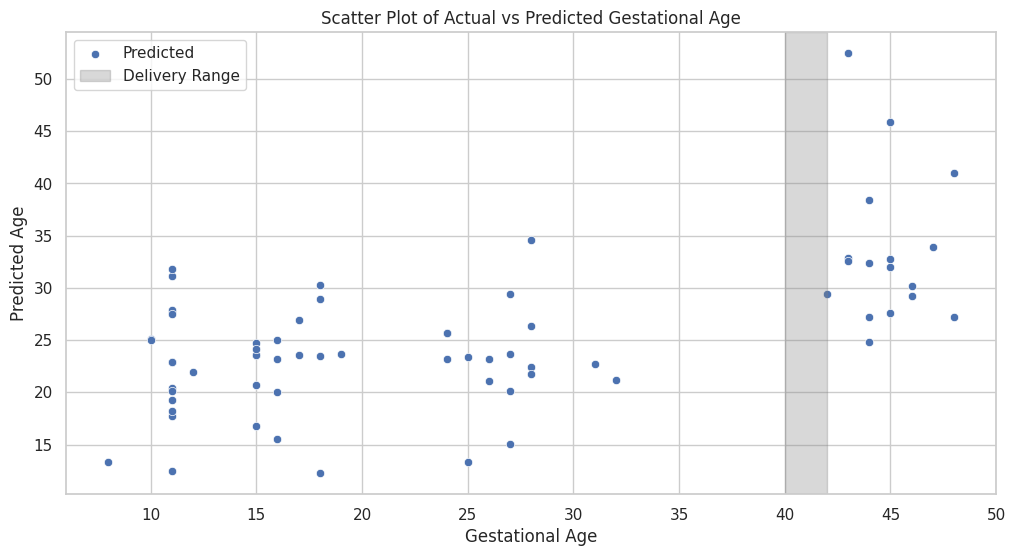

Mean Squared Error for Stacked Model: 112.6673585989285


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity


class GestationalAgePredictor:
    def __init__(self, data, subject_ids):
        self.data = data
        self.subject_ids = subject_ids
        self.X = self.data.drop(columns=['gestational_age'])  # Exclude the target column
        self.y = self.data['gestational_age']
        self.logo_outer = LeaveOneGroupOut()

    def train_elastic_net(self, X_train, y_train, groups):
        # Train Elastic Net model with inner cross-validation for hyperparameter tuning
        parameters = {'elasticnet__alpha': [0.1, 1, 10], 'elasticnet__l1_ratio': [0.1, 0.5, 0.9]}
        elastic_net_model = ElasticNet()
        pipeline = make_pipeline(StandardScaler(), elastic_net_model)
        elastic_net_model_cv = GridSearchCV(pipeline, parameters, cv=5)
        elastic_net_model_cv.fit(X_train, y_train)
        return elastic_net_model_cv.best_estimator_

    def train_svm(self, X_train, y_train, groups):
        # Train Support Vector Machine (SVM) model with inner cross-validation for hyperparameter tuning
        parameters = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 0.5, 1]}
        svm_model = SVR(kernel='rbf')
        pipeline = make_pipeline(StandardScaler(), svm_model)
        svm_model_cv = GridSearchCV(pipeline, parameters, cv=5)
        svm_model_cv.fit(X_train, y_train)
        return svm_model_cv.best_estimator_


# Modify the plot_predictions_with_features method
    def plot_predictions_with_features(self, y_true, y_pred, model_name, relevant_features, top_n=10):
        fig, ax1 = plt.subplots(figsize=(12, 8))

        # Get the top N features based on absolute coefficient values
        top_features_idx = np.argsort(np.abs(relevant_features))[::-1][:top_n]
        top_features = self.X.columns[top_features_idx]

        # Line plots for the top N features
        ax2 = ax1.twinx()
        color = 'r'
        for feature in top_features:
            ax2.plot(self.X[feature].astype(float), label=feature, color=color, linestyle='-', alpha=0.7)
            color = 'g' if color == 'r' else 'r'  # Alternate colors

        # Plot lines connecting data points for the actual vs predicted gestational age
        ax2.plot(y_true, y_pred, label=model_name, color='b', linestyle='-', alpha=0.5)
        ax2.scatter(y_true, y_pred, color='b')  # Scatter plot for data points

        ax1.set_xlabel("Actual Gestational Age")
        ax1.set_ylabel("Predicted Gestational Age", color='b')
        ax1.tick_params('y', colors='b')
        ax1.legend(loc='upper left')
        ax2.set_ylabel("Feature Values", color='r')
        ax2.tick_params('y', colors='r')
        # Add legend for the second y-axis
        lines, labels = ax2.get_legend_handles_labels()
        ax2.legend(lines, labels, loc='upper right')
        plt.title(f"{model_name} - Actual vs Predicted Gestational Age with Top {top_n} Features")
        plt.show()


    def evaluate_models(self):
        # Initialize arrays to store predictions and true values
        y_true = []
        y_pred_stacked = []

        # Perform two-layer cross-validation
        for train_idx, test_idx in self.logo_outer.split(self.X, self.y, groups=self.subject_ids):
            X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_test, y_test = self.X.iloc[test_idx], self.y.iloc[test_idx]

            # Train Elastic Net model with inner cross-validation
            elastic_net_model = self.train_elastic_net(X_train, y_train, groups=self.subject_ids[train_idx])

            # Train SVM model with inner cross-validation
            svm_model = self.train_svm(X_train, y_train, groups=self.subject_ids[train_idx])

            # Stacking: Create a StackingRegressor with Elastic Net and SVM as base estimators
            stacked_model = StackingRegressor(estimators=[('elastic_net', elastic_net_model),
                                                         ('svm', svm_model)],
                                              final_estimator=ElasticNet())
            stacked_model.fit(X_train, y_train)
            # Store true values
            y_true.extend(y_test)

            # Predict using the trained Stacked model
            y_pred_stacked.extend(stacked_model.predict(X_test))

        # Create a DataFrame with true and predicted values
        result_df = pd.DataFrame({'Gestational Age': y_true, 'Predicted Age': y_pred_stacked})
        # Visualize the data using a scatter plot
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        # Scatter plot for Actual vs Predicted Gestational Age
        sns.scatterplot(x='Gestational Age', y='Predicted Age', data=result_df, label='Predicted')
        # Highlight the delivery range in gray
        plt.axvspan(40, 42, color='gray', alpha=0.3, label='Delivery Range')
        plt.xlabel("Gestational Age")
        plt.ylabel("Predicted Age")
        plt.title("Scatter Plot of Actual vs Predicted Gestational Age")
        plt.legend()
        plt.show()
        # Calculate mean squared error for Stacked model
        mse_stacked = mean_squared_error(y_true, y_pred_stacked)
        print("Mean Squared Error for Stacked Model:", mse_stacked)

# Usage
if __name__ == "__main__":
    p = GestationalAgePredictor(data=immune_system, subject_ids=immune_system['Study Subject ID Number'])
    p.evaluate_models()

The below Mentioned code selects features using mutual information, trains multiple models (Elastic Net, Lasso, Ridge, SVM), evaluates them using Mean Squared Error, and finally plots the predictions for the best model.

Elastic_net MSE: 122.90676268395156
Lasso MSE: 112.81969401667776
Ridge MSE: 72.10976107211619
Svm MSE: 106.82913982072412
Best model: Ridge with MSE: 72.10976107211619


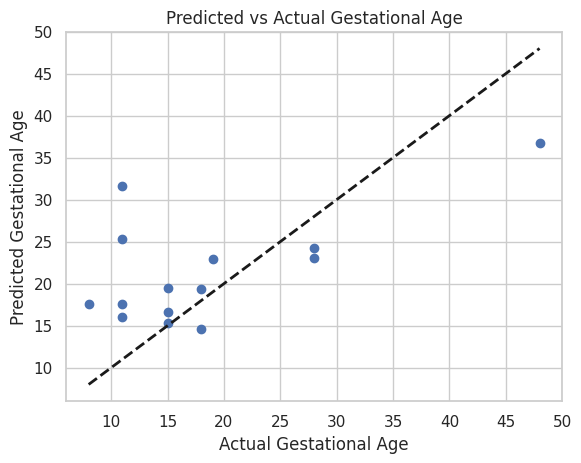

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error

class GestationalAgePredictor:
    def __init__(self, data, target_column='gestational_age'):
        self.data = data
        self.target_column = target_column
        self.X = self.data.drop(columns=[self.target_column])
        self.y = self.data[self.target_column]

    def bootstrap_features(self, n_iterations=100, n_samples=57):
        feature_counts = []
        for _ in range(n_iterations):
            samples = np.random.choice(self.X.index, size=n_samples, replace=True)
            X_sampled = self.X.loc[samples]
            y_sampled = self.y.loc[samples]  # Sample corresponding target values
            mi = SelectKBest(score_func=mutual_info_regression, k='all').fit(X_sampled, y_sampled)
            feature_counts.append(sum(mi.scores_ > 0))
        feature_counts = np.array(feature_counts)
        thresholds = np.arange(0, 1, 0.05)
        feature_numbers = [np.sum(feature_counts > threshold * n_iterations) for threshold in thresholds]
        best_threshold_index = np.argmin(np.abs(np.array(feature_numbers) - self.X.shape[1]))
        best_threshold = thresholds[best_threshold_index]
        best_feature_count = feature_numbers[best_threshold_index]
        return best_feature_count


    def select_features(self, threshold=None):
        if threshold is None:
            threshold = self.bootstrap_features()
        mi = SelectKBest(score_func=mutual_info_regression, k=threshold).fit(self.X, self.y)
        self.X_selected = self.X.loc[:, mi.get_support()]
        return self.X_selected

    def train_model(self, model_name='elastic_net', **kwargs):
        if model_name == 'elastic_net':
            model = ElasticNet(**kwargs)
        elif model_name == 'lasso':
            model = Lasso(**kwargs)
        elif model_name == 'ridge':
            model = Ridge(**kwargs)
        elif model_name == 'svm':
            model = SVR(**kwargs)
        else:
            raise ValueError("Invalid model name")

        self.model = model.fit(self.X_selected, self.y)
        return self.model

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    def plot_predictions(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        plt.scatter(y_test, y_pred)
        plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', lw=2)
        plt.xlabel('Actual Gestational Age')
        plt.ylabel('Predicted Gestational Age')
        plt.title('Predicted vs Actual Gestational Age')
        plt.show()

# A
# Initialize the predictor
predictor = GestationalAgePredictor(immune_system)

# Select features
predictor.select_features()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictor.X_selected, predictor.y, test_size=0.2, random_state=42)

# Train and evaluate models
models = ['elastic_net', 'lasso', 'ridge', 'svm']
best_model = None
best_mse = float('inf')

for model_name in models:
    predictor.train_model(model_name)
    mse = predictor.evaluate_model(X_test, y_test)
    print(f"{model_name.capitalize()} MSE: {mse}")
    if mse < best_mse:
        best_model = model_name
        best_mse = mse

print(f"Best model: {best_model.capitalize()} with MSE: {best_mse}")

# Plot predictions for the best model
predictor.train_model(best_model)
predictor.plot_predictions(X_test, y_test)


In [ ]:

# Import necessary libraries
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from xgboost import XGBRegressor
from scipy.stats import spearmanr
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.preprocessing import StandardScaler


class GestationalAgePredictor:
    def __init__(self, data, subject_ids):
        self.data = data
        self.subject_ids = subject_ids
        self.X = self.data.drop(columns=['gestational_age'])  # Exclude the target column
        self.y = self.data['gestational_age']
        self.logo_outer = LeaveOneGroupOut()
        self.scaler = StandardScaler()

    def train_elastic_net(self, X_train, y_train, groups):
        # Standardize features
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Train Elastic Net model with inner cross-validation for hyperparameter tuning
        parameters = {'elasticnet__alpha': [0.1, 1, 10], 'elasticnet__l1_ratio': [0.1, 0.5, 0.9]}
        elastic_net_model = ElasticNet(max_iter=10000)  # Increase max_iter
        pipeline = make_pipeline(elastic_net_model)
        elastic_net_model_cv = GridSearchCV(pipeline, parameters, cv=5)
        elastic_net_model_cv.fit(X_train_scaled, y_train)
        return elastic_net_model_cv.best_estimator_

    def train_svm(self, X_train, y_train, groups):
        # Train Support Vector Machine (SVM) model with inner cross-validation for hyperparameter tuning
        parameters = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 0.5, 1]}
        svm_model = SVR(kernel='rbf')
        pipeline = make_pipeline(StandardScaler(), svm_model)
        svm_model_cv = GridSearchCV(pipeline, parameters, cv=5)
        svm_model_cv.fit(X_train, y_train)
        return svm_model_cv.best_estimator_

    def train_random_forest(self, X_train, y_train, groups):
        rf_model = RandomForestRegressor()
        parameters = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
        rf_model_cv = GridSearchCV(rf_model, parameters, cv=5)
        rf_model_cv.fit(X_train, y_train)
        return rf_model_cv.best_estimator_

    def train_gaussian_process(self, X_train, y_train, groups):
        # Define the kernel with length_scale_bounds parameter
        kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e10)) \
                 + 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e10), nu=1.5)

        # Train Gaussian Process model
        gp_model = GaussianProcessRegressor(kernel=kernel, random_state=0)
        gp_model.fit(X_train, y_train)
        return gp_model

    def train_xgboost(self, X_train, y_train, groups):
        xgb_model = XGBRegressor()
        parameters = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
        xgb_model_cv = GridSearchCV(xgb_model, parameters, cv=5)
        xgb_model_cv.fit(X_train, y_train)
        return xgb_model_cv.best_estimator_

    def evaluate_models(self):
        # Initialize arrays to store predictions and true values
        y_true = []
        y_pred_stacked = []

        # Perform two-layer cross-validation
        for train_idx, test_idx in self.logo_outer.split(self.X, self.y, groups=self.subject_ids):
            X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_test, y_test = self.X.iloc[test_idx], self.y.iloc[test_idx]

            # Train Elastic Net model with inner cross-validation
            elastic_net_model = self.train_elastic_net(X_train, y_train, groups=self.subject_ids[train_idx])

            # Train SVM model with inner cross-validation
            svm_model = self.train_svm(X_train, y_train, groups=self.subject_ids[train_idx])

            # Train Random Forest model with inner cross-validation
            rf_model = self.train_random_forest(X_train, y_train, groups=self.subject_ids[train_idx])

            # Train Gaussian Process model
            gp_model = self.train_gaussian_process(X_train, y_train, groups=self.subject_ids[train_idx])

            # Train XGBoost model with inner cross-validation
            xgb_model = self.train_xgboost(X_train, y_train, groups=self.subject_ids[train_idx])

            # Stacking: Create a StackingRegressor with Elastic Net, SVM, Random Forest, Gaussian Process, and XGBoost as base estimators
            stacked_model = StackingRegressor(estimators=[('elastic_net', elastic_net_model),
                                                          ('svm', svm_model),
                                                          ('rf', rf_model),
                                                          ('gp', gp_model),
                                                          ('xgb', xgb_model)],
                                               final_estimator=ElasticNet())
            stacked_model.fit(X_train, y_train)
            # Store true values
            y_true.extend(y_test)

            # Predict using the trained Stacked model
            y_pred_stacked.extend(stacked_model.predict(X_test))

        # Create a DataFrame with true and predicted values
        result_df = pd.DataFrame({'Gestational Age': y_true, 'Predicted Age': y_pred_stacked})
        # Visualize the data using a scatter plot
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        # Scatter plot for Actual vs Predicted Gestational Age
        sns.scatterplot(x='Gestational Age', y='Predicted Age', data=result_df, label='Predicted')
        # Highlight the delivery range in gray
        plt.axvspan(40, 42, color='gray', alpha=0.3, label='Delivery Range')
        plt.xlabel("Gestational Age")
        plt.ylabel("Predicted Age")
        plt.title("Scatter Plot of Actual vs Predicted Gestational Age")
        plt.legend()
        plt.show()
        # Calculate mean squared error for Stacked model
        mse_stacked = mean_squared_error(y_true, y_pred_stacked)
        print("Mean Squared Error for Stacked Model:", mse_stacked)

# Usage
if __name__ == "__main__":
    p = GestationalAgePredictor(data=immune_system, subject_ids=immune_system['Study Subject ID Number'])
    p.evaluate_models()


KeyboardInterrupt: 

In [ ]:
class GestationalAgePredictor:
    def __init__(self, data, subject_ids):
    # def __init__(self, data):
        self.data = data
        self.subject_ids = subject_ids
        self.X = self.data
        self.y = self.data['gestational_age']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def train_elastic_net(self):
        # Train Elastic Net model
        self.elastic_net_model = ElasticNet()
        self.elastic_net_model.fit(self.X_train, self.y_train)

    def train_svm(self):
        # Train Support Vector Machine (SVM) model
        self.svm_model = SVR(kernel='rbf')
        self.svm_model.fit(self.X_train, self.y_train)

    def evaluate_models(self):
        # Initialize Leave-One-Group-Out cross-validator
        logo = LeaveOneGroupOut()
        # Initialize arrays to store predictions and true values
        y_true = []
        y_pred_elastic_net = []
        y_pred_svm = []

        # Perform leave-one-subject-out cross-validation
        for train_idx, test_idx in logo.split(self.X, self.y, groups=self.subject_ids):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]

            # Train Elastic Net model
            elastic_net_model = ElasticNet()
            elastic_net_model.fit(X_train, y_train)

            # Train SVM model
            svm_model = SVR(kernel='rbf')
            svm_model.fit(X_train, y_train)

            # Evaluate Elastic Net model
            y_pred_elastic_net.extend(elastic_net_model.predict(X_test))
            y_true.extend(y_test)

            # Evaluate SVM model
            y_pred_svm.extend(svm_model.predict(X_test))

        # Calculate mean squared error for Elastic Net model
        mse_elastic_net = mean_squared_error(y_true, y_pred_elastic_net)
        print("Mean Squared Error for Elastic Net:", mse_elastic_net)

        # Calculate mean squared error for SVM model
        mse_svm = mean_squared_error(y_true, y_pred_svm)
        print("Mean Squared Error for SVM:", mse_svm)



In [ ]:
# Usage
if __name__ == "__main__":

    p = GestationalAgePredictor(data=immune_system,subject_ids=immune_system['Study Subject ID Number'])

    # Train models
    p.train_elastic_net()
    p.train_svm()

    # Evaluate models
    # p.subject_ids = immune_system['Study Subject ID Number']
    p.evaluate_models()

Mean Squared Error for Elastic Net: 0.005855448826037634
Mean Squared Error for SVM: 181.36495309914028


In [ ]:
    def evaluate_models(self):
        # Evaluate Elastic Net model
        y_pred_elastic_net = self.elastic_net_model.predict(self.X_test)
        mse_elastic_net = mean_squared_error(self.y_test, y_pred_elastic_net)
        print("Mean Squared Error for Elastic Net:", mse_elastic_net)

        # Evaluate SVM model
        y_pred_svm = self.svm_model.predict(self.X_test)
        mse_svm = mean_squared_error(self.y_test, y_pred_svm)
        print("Mean Squared Error for SVM:", mse_svm)

### Sex of the baby

Try using a neural network in Tensorflow or PyTorch to predict the sex of the baby.

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

2.15.0


In [ ]:
data_multiomics.head(10)

Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                           
0                   T  PTLG002  16661779                   10565    Male   
1                   T  PTLG002  16661779                   10565    Male   
2                   T  PTLG002  16661779                   10565    Male   
3                   T  PTLG002  16661779                   10565    Male   
4                   T  PTLG004  23587868                   10603  Female   
5                   T  PTLG004  23587868                   10603  Female   
6                   T  PTLG004  23587868                   10603  Female   
7                   T  PTLG004  23587868                   10603  Female   
8                   T  PTLG003  16159071                   10604  Female   
9                   T  PTLG003  16159071                   10604  Female   

  sex_bin timepoint gestational_age cellfree_rna                ...  \
                                       0_C2orf76      1_ACTL10  ...   
0       1         1              11     0.312437 -1.892930e-16  ...   
1       1         2              18     0.312437 -1.892930e-16  ...   
2       1         3              32     0.312437 -1.892930e-16  ...   
3       1         4              45     0.312437 -1.892930e-16  ...   
4       0         1              11     5.204209  1.734736e+00  ...   
5       0         2              18     0.000000  0.000000e+00  ...   
6       0         3              27     0.000000  0.000000e+00  ...   
7       0         4              48     0.000000  0.000000e+00  ...   
8       0         1              11     1.849737  0.000000e+00  ...   
9       0         2              15     3.864497  5.520711e-01  ...   

  plasma_somalogic                                                             \
       1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1 1295_SERPINF1   
0           4804.4      2233.0     3610.9     715.8       151.4       37885.8   
1           4086.0      2160.5     2260.4     825.2       161.0       41821.5   
2           4328.0      1818.4     2445.2    1241.8       194.6       45526.1   
3           3442.4      2661.4     3879.2     703.6       153.7       36862.5   
4           4261.9      1804.6     1470.6     526.8       163.0       38938.3   
5           3958.6      1893.3     2277.8     492.5       178.7       39759.9   
6           3672.8      1675.5     1519.5     725.2       208.7       47422.8   
7           3500.8      2148.7     2311.4     540.1       207.4       38437.8   
8           5023.5      2108.8     2679.9     363.0       191.8       32384.0   
9           5291.9      2005.6     2167.6     552.5       182.9       32540.4   

                                              
  1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0    1479.1    3261.8      561.3      3227.0  
1    1465.1    1839.8      597.8      3366.0  
2    1428.3    3057.2      625.7      8703.7  
3    1063.6    7339.7      593.2      2918.9  
4    1170.1    1036.8      552.8      3457.1  
5    1428.6    5832.3      594.5      3843.9  
6    1532.2    2982.7      618.4      6241.6  
7    1199.9    1246.6      622.3      3341.5  
8    1557.6    1950.0      701.3      3179.1  
9    1556.9    3606.4      794.1      3446.4  

[10 rows x 61274 columns]

In [ ]:
# Assuming 'Sex' is the target feature and other columns are predictors
X = data_multiomics.drop(columns=['Sex'])
y = data_multiomics['Sex']

<ipython-input-29-715247f49b91>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data_multiomics.drop(columns=['Sex'])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Step 2: Preprocess the data
# Drop columns with string values
data_multiomics = data_multiomics.select_dtypes(exclude=['object'])

# Encode categorical variables (if any)
# For example, if you have a column 'category' with string values
# data_multiomics['category'] = LabelEncoder().fit_transform(data_multiomics['category'])

# Separate features and target
X = data_multiomics.drop(columns=['sex_bin'])
y = data_multiomics['sex_bin']

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build a neural network
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", accuracy)


<ipython-input-30-a4c7e0824a7f>:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data_multiomics.drop(columns=['sex_bin'])


Epoch 1/10
2/2 [==============================] - 2s 744ms/step - loss: 24690.9707 - accuracy: 0.5116 - val_loss: 71381.9062 - val_accuracy: 0.3636
Epoch 2/10
2/2 [==============================] - 0s 312ms/step - loss: 49302.1172 - accuracy: 0.4651 - val_loss: 20322.5449 - val_accuracy: 0.6364
Epoch 3/10
2/2 [==============================] - 1s 322ms/step - loss: 33508.8828 - accuracy: 0.5349 - val_loss: 13483.4062 - val_accuracy: 0.6364
Epoch 4/10
2/2 [==============================] - 0s 287ms/step - loss: 20992.3379 - accuracy: 0.4186 - val_loss: 5789.7017 - val_accuracy: 0.3636
Epoch 5/10
2/2 [==============================] - 0s 193ms/step - loss: 4993.5742 - accuracy: 0.4884 - val_loss: 235.8594 - val_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 139ms/step - loss: 2522.7432 - accuracy: 0.6744 - val_loss: 10863.3662 - val_accuracy: 0.3636
Epoch 7/10
2/2 [==============================] - 0s 162ms/step - loss: 6644.7720 - accuracy: 0.5349 - val_loss: 4467

### Feedback

It was a mixture of some easier steps with some thought provoking development, as the literature had to be followed and not every step seemed explicitly clear(seemed that both literature review and description of model were occuring concurrently). I previously worked with IDS data, I was planning to employ LASSO, and then take the non-zero columns to analyze the rest of features via Mutual Information, maybe I will continue to develop it, as I have all those methods already built at my disposal.